### **This Notebook Detects Representative Spectra within each Surface**

This is done by building a similarity graph between each spectra, based on the Gaussian Kernel, then detecting the most representative spectra within each surface based on the PageRank centrality.

Import relevant libraries and import raw data

In [1]:
import seaborn as sns
import pandas as pd
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
import os
from neo4j import GraphDatabase
import shutil
import subprocess
from sklearn.model_selection import cross_validate, GroupKFold
from sklearn.ensemble import ExtraTreesClassifier

In [2]:
os_name = os.name

if os_name == 'nt':
    password = os.getenv('NEO4J_Password')
    neo4j_directory = os.getenv('NEO4J_Directory')
else:
    password = os.environ['NEO4J_Password']
    neo4j_directory = os.environ['NEO4J_Directory']

In [3]:
df = pd.read_csv("../../data/current_clean_spectrum.csv")

In [4]:
df_original = df

In [5]:
#sns.lineplot(data=df, x='WaveNumber', y='Absorbance', hue='Status', errorbar=('ci', False))

In [7]:
pivoted_df = df.pivot(index='SpecID', columns='WaveNumber', values='Absorbance').reset_index()
pivoted_df.columns.name = None

statuses = df[['SpecID', 'Status']].drop_duplicates()

pivoted_df = pd.merge(pivoted_df, statuses, on='SpecID')
pivoted_df = pivoted_df.set_index('SpecID')

pivoted_df.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.3053,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,41.863303,41.803843,41.741884,41.677722,41.611654,41.543974,41.474980,41.404968,41.334234,41.263073,...,6.942749,6.280946,5.549559,4.745724,3.866578,2.909255,1.870891,0.748623,-0.460415,Normal
201210-1-01,46.314608,47.323684,48.299209,49.241395,50.150457,51.026608,51.870063,52.681035,53.459738,54.206386,...,6.322524,6.769011,7.280928,7.861246,8.512936,9.238972,10.042323,10.925962,11.892860,Normal
201210-1-02,118.159018,114.686240,111.563911,108.777452,106.312282,104.153823,102.287493,100.698715,99.372907,98.295491,...,-4.668874,-4.633601,-4.557349,-4.439365,-4.278894,-4.075180,-3.827470,-3.535010,-3.197043,Normal
201210-1-03,175.466997,174.846086,174.188020,173.498226,172.782129,172.045155,171.292728,170.530275,169.763222,168.996993,...,-11.220152,-10.801936,-10.349539,-9.864191,-9.347124,-8.799567,-8.222752,-7.617909,-6.986269,Normal
201210-1-04,111.814973,106.629998,101.867380,97.512673,93.551430,89.969205,86.751551,83.884023,81.352173,79.141556,...,-11.600625,-11.689508,-11.752441,-11.789205,-11.799583,-11.783357,-11.740310,-11.670224,-11.572882,Normal


In [8]:
status_df = df.groupby('SpecID')[['SurID', 'Status']].first()

>#### **Calculate an adjacency matrix using a Gaussian Kernel**

In [9]:
from scipy.spatial.distance import pdist, squareform

# Drop the 'Status' column as it is not numeric
X = pivoted_df.drop(columns=['Status'])

# Calculate pairwise Euclidean distances
distances = pdist(X.values, metric='euclidean')

# Convert the condensed distances to a square matrix form
distance_matrix = squareform(distances)

In [10]:
node_df = status_df.reset_index()
node_df.rename(columns={'SpecID':'SpecID:ID', 'Status':'Status:LABEL', 'SurID':'SurID:LABEL'}, inplace=True)
node_df

,SpecID:ID,SurID:LABEL,Status:LABEL
0,201210-1-00,201210-1,Normal
1,201210-1-01,201210-1,Normal
2,201210-1-02,201210-1,Normal
3,201210-1-03,201210-1,Normal
4,201210-1-04,201210-1,Normal
...,...,...,...
3040,210526-3-45,210526-3,Hyperglycemia
3041,210526-3-46,210526-3,Hyperglycemia
3042,210526-3-47,210526-3,Hyperglycemia
3043,210526-3-48,210526-3,Hyperglycemia


In [11]:
node_df.to_csv(f"{neo4j_directory}/import/nodes.csv", index=False)

In [12]:
pagerank_dfs = []

def project_graph(tx, surface):
    query = """
    CALL gds.graph.project(
      'myGraph', 
      $nodeLabel,
      {
        LINK: {
          orientation: 'UNDIRECTED',
          properties: 'Weight'
        }
      }
    )
    """
    tx.run(query, nodeLabel=surface)

def delete_projection(tx):
    query = """
    CALL gds.graph.drop('myGraph')
    """
    tx.run(query)

def run_pagerank_centrality(tx):
    query = """
    CALL gds.pageRank.stream('myGraph', {
        relationshipWeightProperty: 'Weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["score"]) for record in results]

In [13]:
def prepare_wavelength_df(df, absorbance_col, status_col='Status'):

    # Pivot the DataFrame to get wavelengths as columns and absorbance values
    wavelength_df = df.pivot(index='SpecID', columns='WaveNumber', values=absorbance_col).reset_index()
    wavelength_df.columns.name = None

    # Merge with the statuses based on SpecID
    # Include the SurID to perform GroupKFold CV
    statuses_and_surface = df[['SpecID', 'SurID', status_col]].drop_duplicates()
    wavelength_df = pd.merge(wavelength_df, statuses_and_surface, on='SpecID')

    # Set SpecID as the index
    wavelength_df = wavelength_df.set_index('SpecID')

    return wavelength_df

In [14]:
def evaluate_extra_trees(df):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)

    scores = cross_validate(et, X, y, groups=groups, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])

    # Displaying the results
    print(f"{et.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores['test_accuracy']):.4f} +/- {np.std(scores['test_accuracy']):.4f}")
    print(f"{et.__class__.__name__} Cross-Validation Precision: {np.mean(scores['test_precision_macro']):.4f} +/- {np.std(scores['test_precision_macro']):.4f}")
    print(f"{et.__class__.__name__} Cross-Validation Recall: {np.mean(scores['test_recall_macro']):.4f} +/- {np.std(scores['test_recall_macro']):.4f}")
    print(f"{et.__class__.__name__} Cross-Validation F1-Score: {np.mean(scores['test_f1_macro']):.4f} +/- {np.std(scores['test_f1_macro']):.4f}")

In [17]:
def compare_extra_trees(df):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)

    scores = cross_validate(et, X, y, groups=groups, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])

    # Displaying the results
    return np.mean(scores['test_accuracy'])

In [15]:

def compare_sigma(sigma):
    def gaussian_kernel(distances, sigma):
        return np.exp(-distances**2 / (2 * sigma**2))

    # Sigma is the bandwidth parameter
    kernel_matrix = gaussian_kernel(distance_matrix, sigma)

    # Convert the kernel matrix to a DataFrame
    kernel_df = pd.DataFrame(kernel_matrix, index=pivoted_df.index, columns=pivoted_df.index)

    relationship_df = kernel_df.reset_index()
    relationship_df = relationship_df.melt(id_vars='SpecID', var_name=':END_ID', value_name='Weight:float')
    relationship_df = relationship_df.rename(columns={'SpecID': ':START_ID'})
    relationship_df[':TYPE'] = 'LINK'
    relationship_df = relationship_df[relationship_df[":START_ID"] != relationship_df[":END_ID"]]
    relationship_df = relationship_df[relationship_df[":START_ID"] < relationship_df[":END_ID"]]

    relationship_df.to_csv(f"{neo4j_directory}/import/relationships.csv", index=False)

    os_name = os.name

    if os_name == 'nt':
        working_dir = f'{neo4j_directory}/bin'
        command = 'neo4j-admin database import full --nodes=import/nodes.csv --relationships=import/relationships.csv --overwrite-destination neo4j'
        result = subprocess.run(command, shell=True, cwd=working_dir, capture_output=True, text=True)
    else:
        working_dir = f'{neo4j_directory}'
        command = [
        './bin/neo4j-admin', 'database', 'import', 'full',
        '--nodes=import/nodes.csv',
        '--relationships=import/relationships.csv',
        '--overwrite-destination',  'neo4j'
        ]
        result = subprocess.run(command, cwd=working_dir, stdout=subprocess.PIPE, stderr=subprocess.PIPE)


    # Check if the command was successful
    if result.returncode == 0:
        print("Import successful")
        print(result.stdout)
    else:
        print("Error during import:")
        print(result.stderr)

    if os_name != 'nt':
        command = [
            './bin/neo4j', 'restart'
        ]

        result = subprocess.run(command, cwd=neo4j_directory, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

        # Check if the command was successful
        if result.returncode == 0:
            print("Restart successful")
            print(result.stdout)
        else:
            print("Error during restart:")
            print(result.stderr)


    from neo4j import GraphDatabase

    uri = "neo4j://localhost:7687"
    username = "neo4j"              # Neo4J username
    #Password defined at the top of the notebook

    # Create a driver instance
    driver = GraphDatabase.driver(uri, auth=(username, password))

    # Ensure you close the driver connection when your program ends
    def close_driver():
        driver.close()

    surfaces = status_df['SurID'].unique()

    pagerank_dfs = []

    for surface in surfaces:
        with driver.session() as session:
            session.execute_write(project_graph, surface)
            pagerank_results = session.execute_read(run_pagerank_centrality)
            pagerank_df = pd.DataFrame(pagerank_results, columns=['name', 'PageRank'])
            pagerank_df['SurfacePageRankRank'] = pagerank_df['PageRank'].rank(method='dense', ascending=False)  # Get the rank of centrality of each spectra within the surface
            pagerank_df['ReverseSurfacePageRankRank'] = pagerank_df['PageRank'].rank(method='dense')  # Get the rank of centrality of each spectra within the surface
            pagerank_dfs.append(pagerank_df)
            session.execute_write(delete_projection)

    close_driver()

    pagerank_results = pd.concat(pagerank_dfs).rename(columns={'name':'SpecID'})

    df = df_original
    df = df.merge(pagerank_results, on='SpecID')

    percentage=[]
    acurate=[]

    for num in np.arange(0.1, 1.2, 0.1):
        PageRank_filter = df[df['PageRank'] > num]
        filtered_representative_wavelength_df = prepare_wavelength_df(PageRank_filter, 'Absorbance')
        accuracy = compare_extra_trees(filtered_representative_wavelength_df)
        percentage.append(num)
        acurate.append(accuracy)

    test_results = pd.DataFrame({'Percentage Cutoff':percentage, 'Accuracy':acurate})

    test_results['Sigma'] = sigma

    return test_results

In [18]:
main_df = pd.DataFrame(columns=['Percentage Cutoff','Accuracy', 'Sigma'])

for sigma in range(2700, 3301, 100):
    curerent_df = compare_sigma(sigma)
    main_df = pd.concat([main_df, curerent_df], ignore_index=True)
    print(sigma)

Import successful
b"Neo4j version: 5.12.0\nImporting the contents of these files into /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/data/databases/neo4j:\nNodes:\n  /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/import/nodes.csv\n\nRelationships:\n  /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/import/relationships.csv\n\n\nAvailable resources:\n  Total machine memory: 15.47GiB\n  Free machine memory: 5.715GiB\n  Max heap memory : 910.5MiB\n  Max worker threads: 8\n  Configured max memory: 4.368GiB\n  High parallel IO: true\n\nCypher type normalization is enabled (disable with --normalize-types=false):\n  Property type of 'Weight' normalized from 'float' --> 'double' in /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/import/relationships.csv\n\nImport s

Unable to retrieve routing information
Transaction failed and will be retried in 0.8327305422272135s (Unable to retrieve routing information)


Restart successful
b'Stopping Neo4j........ stopped.\nConfiguration file validation successful (with warnings).\nDirectories in use:\nhome:         /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5\nconfig:       /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/conf\nlogs:         /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/logs\nplugins:      /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/plugins\nimport:       /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/import\ndata:         /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/data\ncertificates: /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ff

Unable to retrieve routing information
Transaction failed and will be retried in 1.8177975853449395s (Unable to retrieve routing information)
Unable to retrieve routing information
Transaction failed and will be retried in 4.053177788365067s (Unable to retrieve routing information)
Unable to retrieve routing information
Transaction failed and will be retried in 6.597453017637331s (Unable to retrieve routing information)
Unable to retrieve routing information
Transaction failed and will be retried in 17.413657499906527s (Unable to retrieve routing information)
/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Reca

In [27]:
main_df['Accuracy'].max()

0.6688268169090177

In [ ]:
main_df.to_csv('../../data/sigma_pagerank_testing.csv', index=False)

<Axes: xlabel='Sigma', ylabel='Accuracy'>

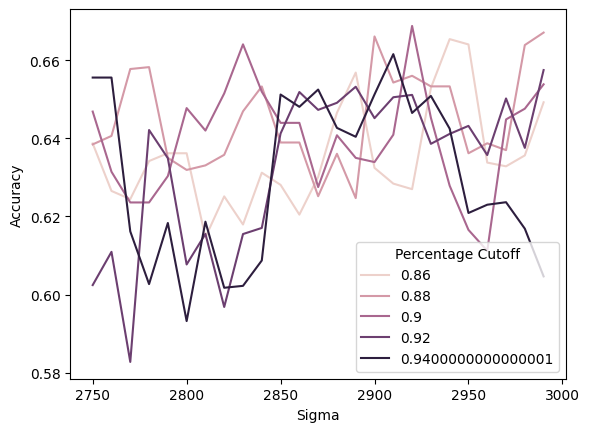

In [28]:
sns.lineplot(data=main_df, x='Sigma', y='Accuracy', hue='Percentage Cutoff')

In [49]:
wavelength_df = prepare_wavelength_df(df, 'Absorbance')

In [50]:
wavelength_df

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,SurID,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,41.863303,41.803843,41.741884,41.677722,41.611654,41.543974,41.474980,41.404968,41.334234,41.263073,...,6.280946,5.549559,4.745724,3.866578,2.909255,1.870891,0.748623,-0.460415,201210-1,Normal
201210-1-01,46.314608,47.323684,48.299209,49.241395,50.150457,51.026608,51.870063,52.681035,53.459738,54.206386,...,6.769011,7.280928,7.861246,8.512936,9.238972,10.042323,10.925962,11.892860,201210-1,Normal
201210-1-02,118.159018,114.686240,111.563911,108.777452,106.312282,104.153823,102.287493,100.698715,99.372907,98.295491,...,-4.633601,-4.557349,-4.439365,-4.278894,-4.075180,-3.827470,-3.535010,-3.197043,201210-1,Normal
201210-1-03,175.466997,174.846086,174.188020,173.498226,172.782129,172.045155,171.292728,170.530275,169.763222,168.996993,...,-10.801936,-10.349539,-9.864191,-9.347124,-8.799567,-8.222752,-7.617909,-6.986269,201210-1,Normal
201210-1-04,111.814973,106.629998,101.867380,97.512673,93.551430,89.969205,86.751551,83.884023,81.352173,79.141556,...,-11.689508,-11.752441,-11.789205,-11.799583,-11.783357,-11.740310,-11.670224,-11.572882,201210-1,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210526-3-45,11.003178,12.008451,12.879986,13.624553,14.248922,14.759862,15.164145,15.468539,15.679816,15.804744,...,6.671003,7.197072,7.711103,8.211164,8.695324,9.161650,9.608210,10.033072,210526-3,Hyperglycemia
210526-3-46,14.239653,13.596345,12.981340,12.396227,11.842591,11.322020,10.836101,10.386421,9.974566,9.602123,...,2.124074,2.718437,3.405898,4.190762,5.077335,6.069920,7.172824,8.390352,210526-3,Hyperglycemia
210526-3-47,17.165901,17.349777,17.457499,17.494696,17.466999,17.380039,17.239446,17.050852,16.819887,16.552181,...,6.895403,7.740965,8.633346,9.572405,10.558000,11.589990,12.668233,13.792588,210526-3,Hyperglycemia


In [51]:
evaluate_extra_trees(wavelength_df)

/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ExtraTreesClassifier Cross-Validation Accuracy: 0.6123 +/- 0.1083
ExtraTreesClassifier Cross-Validation Precision: 0.6069 +/- 0.1072
ExtraTreesClassifier Cross-Validation Recall: 0.6205 +/- 0.1331
ExtraTreesClassifier Cross-Validation F1-Score: 0.5935 +/- 0.1231


#### **Only keep the top k most central spectra**

In [53]:
representative_df = df[df['SurfacePageRankRank'] <= 40]
representative_df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,PageRank,SurfacePageRankRank,ReverseSurfacePageRankRank
0,201210-1-00,293,400.22778,201210-1,Normal,41.863303,1.025972,22.0,28.0
1,201210-1-00,294,400.91116,201210-1,Normal,41.803843,1.025972,22.0,28.0
2,201210-1-00,295,401.59454,201210-1,Normal,41.741884,1.025972,22.0,28.0
3,201210-1-00,296,402.27789,201210-1,Normal,41.677722,1.025972,22.0,28.0
4,201210-1-00,297,402.96127,201210-1,Normal,41.611654,1.025972,22.0,28.0
...,...,...,...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,12.378163,1.043607,7.0,44.0
6239201,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,13.269937,1.043607,7.0,44.0
6239202,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,14.199285,1.043607,7.0,44.0
6239203,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,15.166531,1.043607,7.0,44.0


In [54]:
representative_wavelength_df = prepare_wavelength_df(representative_df, 'Absorbance')
evaluate_extra_trees(representative_wavelength_df)

/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ExtraTreesClassifier Cross-Validation Accuracy: 0.6166 +/- 0.1211
ExtraTreesClassifier Cross-Validation Precision: 0.5976 +/- 0.1310
ExtraTreesClassifier Cross-Validation Recall: 0.5958 +/- 0.1514
ExtraTreesClassifier Cross-Validation F1-Score: 0.5692 +/- 0.1338


/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### **Alternatively, try dropping the least central spectra from each Surface**

In [55]:
representative_df = df[df['ReverseSurfacePageRankRank'] >= 5]
representative_df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,PageRank,SurfacePageRankRank,ReverseSurfacePageRankRank
0,201210-1-00,293,400.22778,201210-1,Normal,41.863303,1.025972,22.0,28.0
1,201210-1-00,294,400.91116,201210-1,Normal,41.803843,1.025972,22.0,28.0
2,201210-1-00,295,401.59454,201210-1,Normal,41.741884,1.025972,22.0,28.0
3,201210-1-00,296,402.27789,201210-1,Normal,41.677722,1.025972,22.0,28.0
4,201210-1-00,297,402.96127,201210-1,Normal,41.611654,1.025972,22.0,28.0
...,...,...,...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,12.378163,1.043607,7.0,44.0
6239201,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,13.269937,1.043607,7.0,44.0
6239202,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,14.199285,1.043607,7.0,44.0
6239203,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,15.166531,1.043607,7.0,44.0


In [56]:
representative_wavelength_df = prepare_wavelength_df(representative_df, 'Absorbance')
evaluate_extra_trees(representative_wavelength_df)

/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stang/.local/lib/python3.10/site-packages/s

ExtraTreesClassifier Cross-Validation Accuracy: 0.5671 +/- 0.1426
ExtraTreesClassifier Cross-Validation Precision: 0.5591 +/- 0.1441
ExtraTreesClassifier Cross-Validation Recall: 0.5230 +/- 0.2073
ExtraTreesClassifier Cross-Validation F1-Score: 0.5013 +/- 0.1682


In [57]:
aggregated_df = df.groupby('SurID')['PageRank'].agg(
    Mean='mean',
    STD='std',
    Median='median',
    Q1=lambda x: x.quantile(0.25),
    Q3=lambda x: x.quantile(0.75)
).reset_index()

/home/stang/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/stang/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [58]:
aggregated_df

,SurID,Mean,STD,Median,Q1,Q3
0,201210-1,0.96124,0.171289,1.019900,0.956013,1.034734
1,201210-2,0.96124,0.313377,1.158139,0.894352,1.182345
2,210114-1,0.96124,0.136424,1.005969,0.982674,1.008425
3,210114-2,0.96124,0.303527,1.012016,0.995164,1.015057
4,210120-1,0.96124,0.307594,1.106397,0.845677,1.195918
...,...,...,...,...,...,...
58,210519-3,0.96124,0.054865,0.978311,0.960862,0.993813
59,210524-1,0.96124,0.035744,0.980746,0.926749,0.985689
60,210526-1,0.96124,0.025409,0.968856,0.954527,0.980351
61,210526-2,0.96124,0.001353,0.961659,0.960654,0.962136


In [59]:
# Step 1: Calculate the 50th percentile of SurfacePageRankRank for each SurID
median_ranks = df.groupby('SurID')['SurfacePageRankRank'].transform(lambda x: x.quantile(0.8))

# Step 2: Keep only the rows with SurfacePageRankRank >= to its group's median
filtered_df = df[df['SurfacePageRankRank'] <= median_ranks]
opposite_df = df[df['SurfacePageRankRank'] >= median_ranks]

In [60]:
fil_sample = filtered_df[filtered_df['SurID'] == '201210-1']
opp_sample = opposite_df[opposite_df['SurID'] == '201210-1']

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

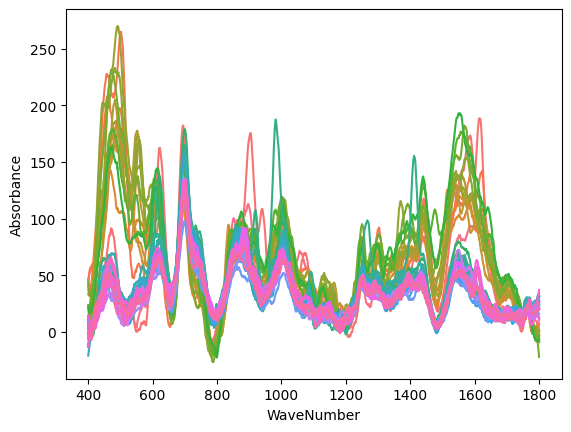

In [61]:
sns.lineplot(data=fil_sample, x='WaveNumber', y='Absorbance', hue='SpecID', errorbar=('ci', False), legend=False)

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

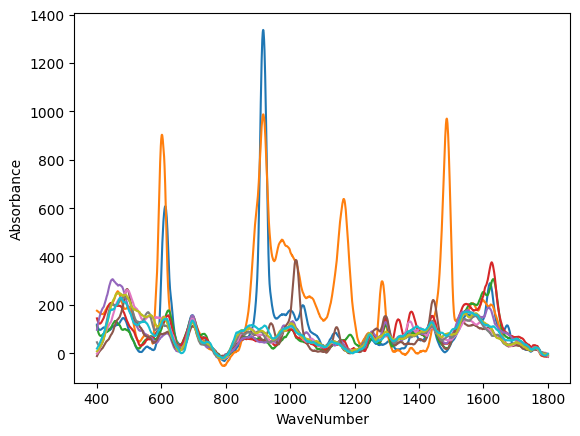

In [62]:
sns.lineplot(data=opp_sample, x='WaveNumber', y='Absorbance', hue='SpecID', errorbar=('ci', False), legend=False)

In [63]:
filtered_representative_wavelength_df = prepare_wavelength_df(filtered_df, 'Absorbance')
evaluate_extra_trees(filtered_representative_wavelength_df)

/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ExtraTreesClassifier Cross-Validation Accuracy: 0.6234 +/- 0.1426
ExtraTreesClassifier Cross-Validation Precision: 0.6051 +/- 0.1192
ExtraTreesClassifier Cross-Validation Recall: 0.5904 +/- 0.1620
ExtraTreesClassifier Cross-Validation F1-Score: 0.5740 +/- 0.1412


In [62]:
percentage = []
acurate = []

for num in np.arange(0.7, 0.86, 0.02):
    median_ranks = df.groupby('SurID')['SurfacePageRankRank'].transform(lambda x: x.quantile(num))
    filtered_df = df[df['SurfacePageRankRank'] <= median_ranks]
    filtered_representative_wavelength_df = prepare_wavelength_df(filtered_df, 'Absorbance')
    accuracy = compare_extra_trees(filtered_representative_wavelength_df)
    percentage.append(num)
    acurate.append(accuracy)

test_results = pd.DataFrame({'Percentage Cutoff':percentage, 'Accuracy':acurate})

/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stang/.local/lib/python3.10/site-packages/s

In [63]:
test_results

,Percentage Cutoff,Accuracy
0,0.70,0.575778
1,0.72,0.567786
2,0.74,0.568304
3,0.76,0.574306
4,0.78,0.570022
5,0.80,0.582188
6,0.82,0.582075
7,0.84,0.565264
8,0.86,0.571059


<Axes: xlabel='Percentage Cutoff', ylabel='Accuracy'>

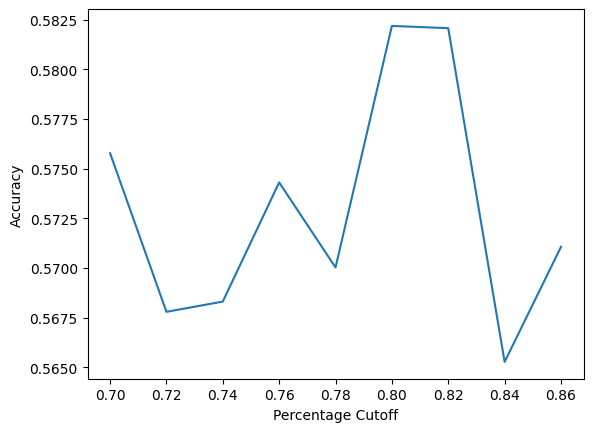

In [64]:
sns.lineplot(data=test_results, y='Accuracy', x='Percentage Cutoff')

## PageRank Cutofff

In [154]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,PageRank,SurfacePageRankRank,ReverseSurfacePageRankRank
0,201210-1-00,293,400.22778,201210-1,Normal,0.241429,0.943418,26.0,24.0
1,201210-1-00,294,400.91116,201210-1,Normal,0.241086,0.943418,26.0,24.0
2,201210-1-00,295,401.59454,201210-1,Normal,0.240729,0.943418,26.0,24.0
3,201210-1-00,296,402.27789,201210-1,Normal,0.240359,0.943418,26.0,24.0
4,201210-1-00,297,402.96127,201210-1,Normal,0.239978,0.943418,26.0,24.0
...,...,...,...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,0.060284,0.999562,25.0,26.0
6239201,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,0.064627,0.999562,25.0,26.0
6239202,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,0.069153,0.999562,25.0,26.0
6239203,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,0.073864,0.999562,25.0,26.0


In [73]:
PageRank_filter = df[df['PageRank'] > 0.86]
opp_PageRank_filter = df[df['PageRank'] <= 0.86]

In [74]:
fil_sample = PageRank_filter[PageRank_filter['SurID'] == '201210-1']
opp_sample = opp_PageRank_filter[opp_PageRank_filter['SurID'] == '201210-1']

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

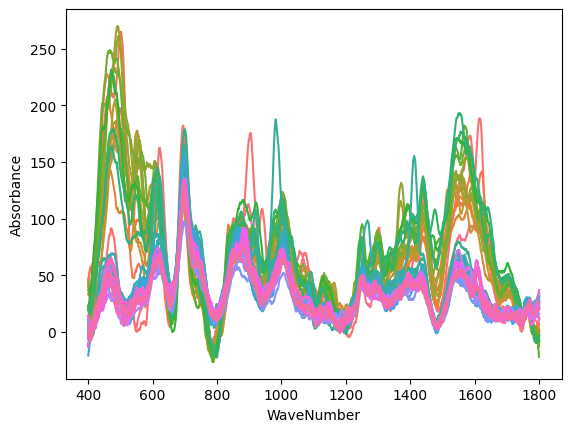

In [75]:
sns.lineplot(data=fil_sample, x='WaveNumber', y='Absorbance', hue='SpecID', errorbar=('ci', False), legend=False)

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

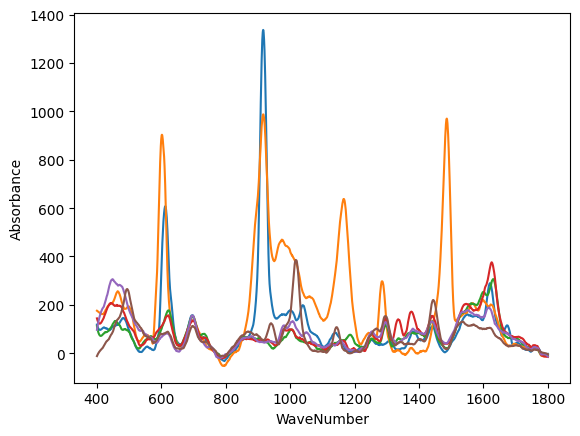

In [76]:
sns.lineplot(data=opp_sample, x='WaveNumber', y='Absorbance', hue='SpecID', errorbar=('ci', False), legend=False)

In [77]:
PageRank_filter.shape

(4491408, 9)

In [81]:
PageRank_filter.groupby('Status')['SpecID'].nunique()

Status
Hyperglycemia    622
Hypoglycemia     746
Normal           824
Name: SpecID, dtype: int64

In [78]:
filtered_representative_wavelength_df = prepare_wavelength_df(PageRank_filter, 'Absorbance')
evaluate_extra_trees(filtered_representative_wavelength_df)

/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ExtraTreesClassifier Cross-Validation Accuracy: 0.6547 +/- 0.0916
ExtraTreesClassifier Cross-Validation Precision: 0.5921 +/- 0.1142
ExtraTreesClassifier Cross-Validation Recall: 0.6159 +/- 0.1012
ExtraTreesClassifier Cross-Validation F1-Score: 0.5788 +/- 0.1263


In [82]:
filtered_representative_wavelength_df.shape

(2192, 2051)

In [70]:
percentage = []
acurate = []

for num in np.arange(0.8, 0.86, 0.005):
    PageRank_filter = df[df['PageRank'] > num]
    filtered_representative_wavelength_df = prepare_wavelength_df(PageRank_filter, 'Absorbance')
    accuracy = compare_extra_trees(filtered_representative_wavelength_df)
    percentage.append(num)
    acurate.append(accuracy)

test_results = pd.DataFrame({'Percentage Cutoff':percentage, 'Accuracy':acurate})

/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stang/.local/lib/python3.10/site-packages/s

In [71]:
test_results

,Percentage Cutoff,Accuracy
0,0.820,0.639959
1,0.825,0.643536
2,0.830,0.650347
3,0.835,0.632562
4,0.840,0.631084
5,0.845,0.637170
6,0.850,0.641630
7,0.855,0.640855
8,0.860,0.654697


<Axes: xlabel='Percentage Cutoff', ylabel='Accuracy'>

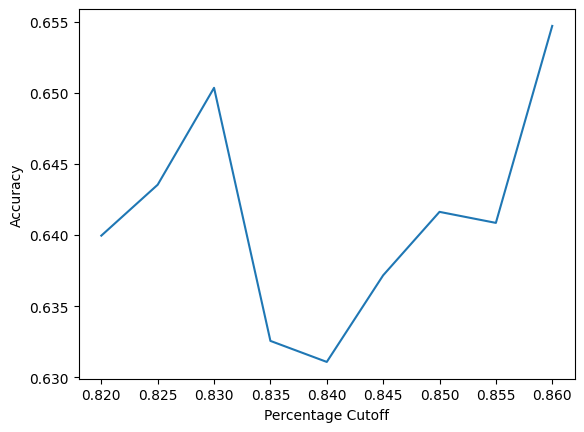

In [72]:
sns.lineplot(data=test_results, y='Accuracy', x='Percentage Cutoff')